# Chapter 5 - Resampling methods

Concepts and data from "An Introduction to Statistical Learning, with applications in R"  (Springer, 2013) with permission from the authors: G. James, D. Witten,  T. Hastie and R. Tibshirani " available at [www.StatLearning.com](http://www.StatLearning.com).

For Tables reference see [http://data8.org/datascience/tables.html](http://data8.org/datascience/tables.html)

In [1]:
# HIDDEN
# For Tables reference see http://data8.org/datascience/tables.html
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
from sklearn import linear_model
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=1, color='r')
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__


import sys
sys.path.append("..")
from ml_table import ML_Table

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

'en_US.UTF-8'

## 5.1 Cross validation

### 5.1.1 The Validation Set Approach

Train on a random half the data, test on the other half.

In [2]:
raw_auto = ML_Table.read_table("data/Auto.csv")
auto = raw_auto.where(raw_auto['horsepower'] != '?')
auto['horsepower'] = auto.apply(int, 'horsepower')

In [3]:
auto

mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
18,8,307,130,"3,504",12,70,1,chevrolet chevelle malibu
15,8,350,165,"3,693",11.5,70,1,buick skylark 320
18,8,318,150,"3,436",11,70,1,plymouth satellite
16,8,304,150,"3,433",12,70,1,amc rebel sst
17,8,302,140,"3,449",10.5,70,1,ford torino
15,8,429,198,"4,341",10,70,1,ford galaxie 500
14,8,454,220,"4,354",9,70,1,chevrolet impala
14,8,440,215,"4,312",8.5,70,1,plymouth fury iii
14,8,455,225,"4,425",10,70,1,pontiac catalina
15,8,390,190,"3,850",8.5,70,1,amc ambassador dpl


In [4]:
auto_poly = auto.poly('mpg', 'horsepower', 2)

In [5]:
# training error

auto.MSE_model('mpg', auto_poly, 'horsepower')

18.984768907617219

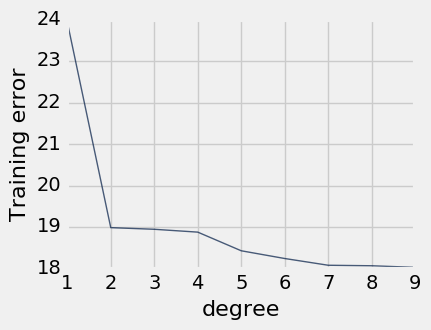

In [6]:
Table().with_columns([
    ('degree', range(1,10)),
    ('Training error', [auto.MSE_model('mpg', auto.poly('mpg', 'horsepower', degree), 'horsepower') for degree in range(1,10)])
]).plot('degree', height=3, width=4)

In [7]:
def poly_cross(tbl, output_label, input_label, max_degree):
    train, test = tbl.split(tbl.num_rows//2)
    return [test.MSE_model(output_label, train.poly(output_label, input_label, deg), input_label) for deg in range(1,max_degree)
           ]

In [8]:
poly_cross(auto, 'mpg', 'horsepower', 10)

[22.153907306205539,
 18.143980839929544,
 18.280279403692781,
 18.194886137328933,
 18.275325687861066,
 18.213835217121328,
 18.017134265766948,
 18.020639985782477,
 18.352172677432851]

In [9]:
auto_poly = Table().with_column('degree', range(1,10))
for k in range(10):
    auto_poly = auto_poly.with_column("run "+str(k), poly_cross(auto, 'mpg', 'horsepower', 10))
auto_poly

degree,run 0,run 1,run 2,run 3,run 4,run 5,run 6,run 7,run 8,run 9
1,24.799,23.466,22.4868,23.7759,25.478,25.8399,24.3811,24.2911,23.5398,22.1828
2,20.075,20.4249,18.1171,17.2199,19.6713,19.1799,19.7684,18.433,21.0931,16.5412
3,20.2118,21.5568,18.0704,17.1147,19.7064,19.2911,19.7174,18.5302,22.0849,16.4889
4,20.2583,21.5555,18.0927,18.941,19.7881,20.202,19.6307,18.8266,22.7447,16.5492
5,19.6832,21.012,18.2573,17.935,19.84,19.3934,19.0186,18.2932,22.5502,15.8957
6,19.6378,20.711,18.323,19.372,19.7009,20.1134,18.8055,18.5826,22.4656,16.142
7,19.5533,20.2027,18.6918,18.5706,19.5829,19.1824,18.5362,18.0202,22.0488,16.2082
8,21.1997,22.8126,19.6871,17.8499,19.8478,23.1287,18.5616,18.076,22.4275,17.3321
9,25.0362,23.2401,20.4802,68.0624,20.1855,24.3317,19.0554,18.1496,22.8569,18.3696


(10, 30)

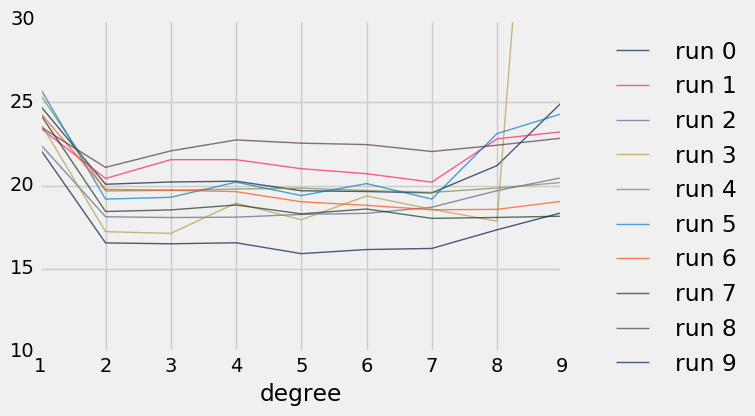

In [68]:
auto_poly.plot('degree')
plots.ylim(10,30)

### Leave out one cross valudation - LOOCV

$CV_n = \frac{1}{n} \sum_{i=1}^{n}MSE_i$

where $MSE_i$ is the test error on the $i$-th row when trained on the remainin $n-1$ rows.  It is slow.

In [23]:
auto.take(13)

mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
14,8,455,225,"3,086",10,70,1,buick estate wagon (sw)


In [36]:
def LOOCV_poly(tbl, output_label, input_labels, degree):
    n = tbl.num_rows
    def split(i):
        return tbl.exclude(i), tbl.take(i)
    MSEs = [test.MSE_model(output_label, 
                           train.poly(output_label, input_labels, degree),
                           input_labels) for train, test in [split(i) for i in range(n)]
            ]
    return np.sum(MSEs)/n

In [37]:
LOOCV_poly(auto, 'mpg', 'horsepower', 1)

24.231513517929233

In [38]:
# This takes a while with 392 * 9 poly fits
auto_poly_loocv = Table().with_column('degree', range(1,10))
auto_poly_loocv['LOOCV'] = [LOOCV_poly(auto, 'mpg', 'horsepower', deg) for deg in auto_poly_loocv['degree'] ]
auto_poly_loocv

degree,LOOCV
1,24.2315
2,19.2482
3,19.335
4,19.4244
5,19.0332
6,18.9786
7,18.833
8,18.9612
9,19.0686


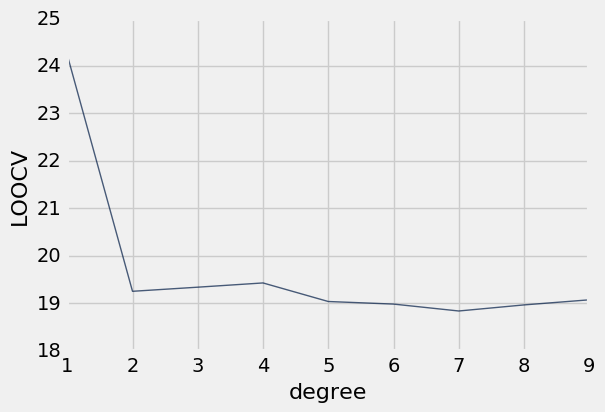

In [70]:
auto_poly_loocv.plot('degree')

In [40]:
auto.num_rows

392

### k-fold cross validation

$CV_k = \frac{1}{k} \sum_{i=1}^{k}MSE_i$

where the data is broken into $k$ groups, trained on $k-1$ of them and tested on the remaining.

In [41]:
auto.take(range(9,13))

mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
15,8,390,190,"3,850",8.5,70,1,amc ambassador dpl
15,8,383,170,"3,563",10,70,1,dodge challenger se
14,8,340,160,"3,609",8,70,1,plymouth 'cuda 340
15,8,400,150,"3,761",9.5,70,1,chevrolet monte carlo


In [63]:
def k_split(tbl, i, k):
    n = tbl.num_rows
    nk = n//k
    fold = range(i*nk, (i+1)*nk)
    return tbl.exclude(fold), tbl.take(fold)

def k_fold_poly(tbl, output_label, input_labels, degree, k):
    MSEs = [test.MSE_model(output_label, 
                           train.poly(output_label, input_labels, degree),
                           input_labels) for train, test in [k_split(tbl, i, k) for i in range(k)]
            ]
    return np.sum(MSEs)/k

In [64]:
k_split(auto, 0, 10)

(mpg  | cylinders | displacement | horsepower | weight | acceleration | year | origin | name
 14   | 8         | 351          | 153        | 4,154  | 13.5         | 71   | 1      | ford galaxie 500
 14   | 8         | 318          | 150        | 4,096  | 13           | 71   | 1      | plymouth fury iii
 12   | 8         | 383          | 180        | 4,955  | 11.5         | 71   | 1      | dodge monaco (sw)
 13   | 8         | 400          | 170        | 4,746  | 12           | 71   | 1      | ford country squire (sw)
 13   | 8         | 400          | 175        | 5,140  | 12           | 71   | 1      | pontiac safari (sw)
 18   | 6         | 258          | 110        | 2,962  | 13.5         | 71   | 1      | amc hornet sportabout (sw)
 22   | 4         | 140          | 72         | 2,408  | 19           | 71   | 1      | chevrolet vega (sw)
 19   | 6         | 250          | 100        | 3,282  | 15           | 71   | 1      | pontiac firebird
 18   | 6         | 250          | 88    

In [65]:
k_fold_poly(auto, 'mpg', 'horsepower', 1, 10)

27.453742881045894

In [66]:
auto_poly_k_fold = Table().with_column('degree', range(1,10))
auto_poly_k_fold['k fold'] = [k_fold_poly(auto, 'mpg', 'horsepower', deg, 10) for deg in auto_poly_k_fold['degree'] ]
auto_poly_k_fold

degree,k fold
1,27.4537
2,21.2252
3,21.3465
4,21.3772
5,20.943
6,20.8014
7,20.6286
8,20.9376
9,20.8231


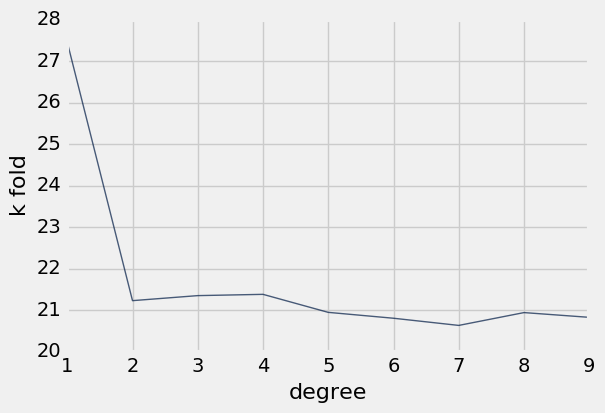

In [67]:
auto_poly_k_fold.plot('degree')

## Cross validation with classification

In [100]:
n = 400
eps = 0.1
test2 = ML_Table.runiform('ix', n)
test2['iy'] = np.random.rand(n)
test2['Cat'] = test2.apply(lambda x, y: 'A' if x+y <0 else 'B', ['ix', 'iy'])
test2['Class A'] = test2.apply(lambda x: 1 if x=='A' else 0, 'Cat')
test2['x'] = test2['ix'] + eps*np.random.normal(size=n)
test2['y'] = test2['iy'] + eps*np.random.normal(size=n)

0.0425

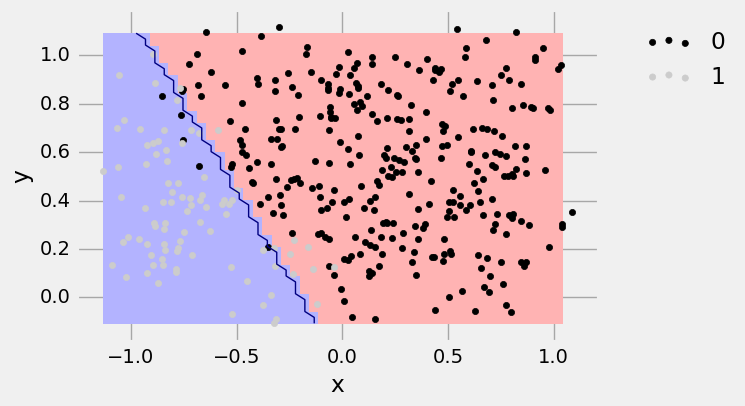

In [101]:
logit2d = test2.logit_regression('Class A', ['x', 'y'])
model_2d = logit2d.model
ax = test2.plot_cut_2d('Class A', 'x', 'y', model_2d, n_grid=50)
test2.classification_error_model('Class A', model_2d, ['x', 'y'])

0.035

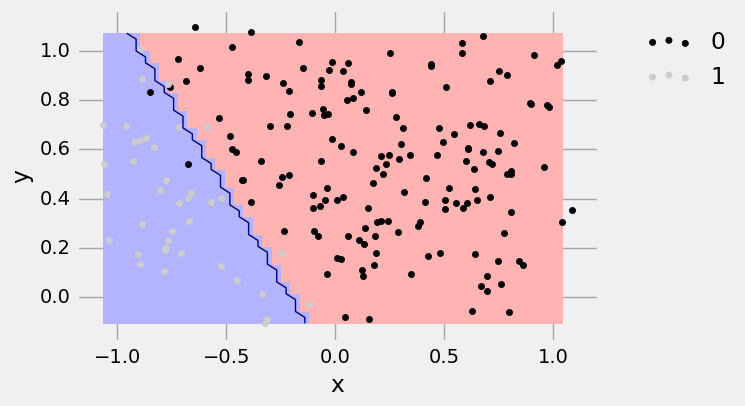

In [102]:
train, test = test2.split(n//2)
classifier = train.logit_regression('Class A', ['x', 'y'])
ax = test.plot_cut_2d('Class A', 'x', 'y', classifier.model, n_grid=50)
test.classification_error_model('Class A', classifier.model, ['x', 'y'])

0.14

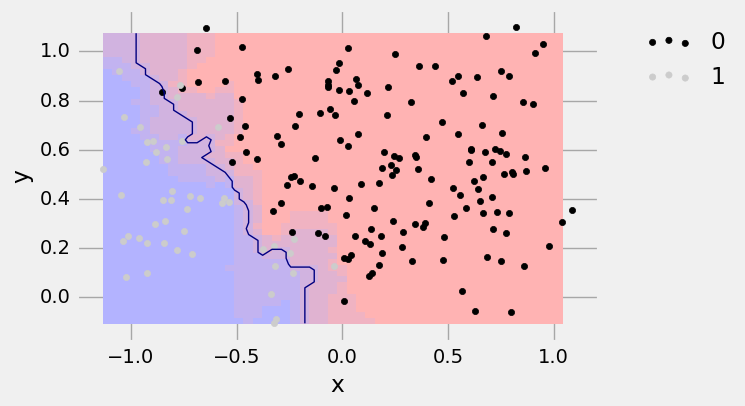

In [103]:
train, test = test2.split(n//2)
classifier = train.knn_regression('Class A', ['x', 'y'], n_neighbors=5)
ax = test.plot_cut_2d('Class A', 'x', 'y', classifier.model, n_grid=50)
test.classification_error_model('Class A', classifier.model, ['x', 'y'])

0.045

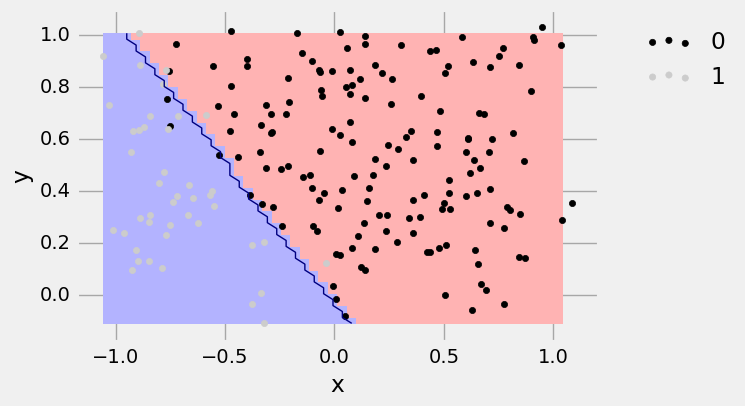

In [104]:
train, test = test2.split(n//2)
classifier = train.LDA('Class A', ['x', 'y'])
ax = test.plot_cut_2d('Class A', 'x', 'y', classifier.model, n_grid=50)
test.classification_error_model('Class A', classifier.model, ['x', 'y'])

## K-Fold Cross Validation

In [116]:
def k_split(tbl, i, k):
    n = tbl.num_rows
    nk = n//k
    fold = range(i*nk, (i+1)*nk)
    return tbl.exclude(fold), tbl.take(fold)

def k_error(i, k, tbl, classifier, output_label, input_labels, **kwargs):
    train, test = k_split(tbl, i, k)
    return test.classification_error_model(output_label, 
                                           classifier(train, output_label, input_labels, **kwargs).model,
                                           input_labels)

def k_fold(k, tbl, classifier, output_label, input_labels, **kwargs):
    return [k_error(i, k, tbl, classifier, output_label, input_labels, **kwargs) for i in range(k)]

In [119]:
k_error(0, 10, test2, ML_Table.LDA, 'Class A', ['x', 'y'])

0.05

In [120]:
k_fold(10, test2, ML_Table.logit_regression, 'Class A', ['x', 'y'])

[0.05, 0.05, 0.025, 0.025, 0.075, 0.025, 0.075, 0.05, 0.025, 0.0]

In [121]:
k_fold(10, test2, ML_Table.knn_regression, 'Class A', ['x', 'y'])

[0.075, 0.175, 0.075, 0.075, 0.1, 0.15, 0.2, 0.15, 0.125, 0.075]

In [122]:
k_fold(10, test2, ML_Table.LDA, 'Class A', ['x', 'y'])

[0.05, 0.075, 0.025, 0.025, 0.05, 0.0, 0.05, 0.025, 0.0, 0.05]

In [123]:
[np.mean(k_fold(10, test2, ML_Table.logit_regression, 'Class A', ['x', 'y'])),
np.mean(k_fold(10, test2, ML_Table.knn_regression, 'Class A', ['x', 'y'])),
np.mean(k_fold(10, test2, ML_Table.LDA, 'Class A', ['x', 'y']))]

[0.040000000000000001, 0.12, 0.034999999999999996]

## Bootstrap

Using the bootstrap, we can compare the accuracy of our various classifiers

In [138]:
def boot(tbl, classifier, output_label, input_labels, **kwargs):
    test = tbl.sample(tbl.num_rows, with_replacement=True)
    return test.classification_error_model(output_label, 
                                           classifier(test, output_label, input_labels, **kwargs).model,
                                           input_labels)

def bootstrap_classifier(k, tbl, classifier, output_label, input_labels, **kwargs):
    return [boot(tbl, classifier, output_label, input_labels, **kwargs) for i in range(k)]

In [139]:
boot(test2, ML_Table.logit_regression, 'Class A', ['x', 'y'])

0.0525

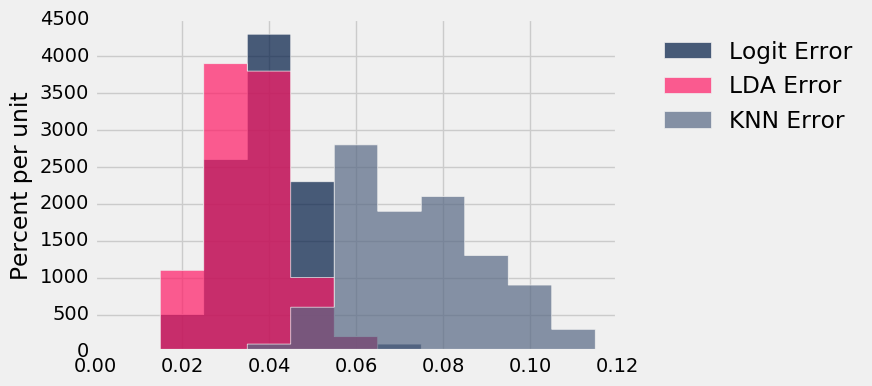

In [142]:
test2_classifiers = Table()
test2_classifiers['Logit Error'] = bootstrap_classifier(100, test2, ML_Table.logit_regression, 'Class A', ['x', 'y'])
test2_classifiers['LDA Error'] = bootstrap_classifier(100, test2, ML_Table.LDA, 'Class A', ['x', 'y'])
test2_classifiers['KNN Error'] = bootstrap_classifier(100, test2, ML_Table.knn_regression, 'Class A', ['x', 'y'])
test2_classifiers.hist()

In [143]:
test2_classifiers.stats(ops=[min, np.mean, np.median, max])

statistic,Logit Error,LDA Error,KNN Error
min,0.02,0.015,0.04
mean,0.037925,0.034625,0.073375
median,0.0375,0.03375,0.0725
max,0.065,0.0625,0.115
